<a href="https://colab.research.google.com/github/Cipe96/EEG-Recognition/blob/main/Analisi_Dataset_e_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6>**EEG Recognition: Analisi Dataset e Preprocessing**</font>
</br><font size=3>*Marco Cipollina, Riccardo Era*</font>


<p style="font-size:4px;" align="justify">In questo notebook viene svolta in primo luogo l'analisi dei dati composto dalla sola prima run ("basale, occhi aperti", escludendo le annotazioni dei file edf.event) del dataset "EEG Motor Movement/Imagery". È possibile trovare informazioni dettagliate riguardo il dataset originale al seguente <a href="https://physionet.org/content/eegmmidb/1.0.0/">link</a>.</p>
<p style="font-size:4px;" align="justify">Oltre che poter osservare gli elementi principali, è possibile svolgere delle analisi specifiche a relativi campioni e volontari.</p>
<p style="font-size:4px;" align="justify">Successivamente viene impostata una fase di pre-processing basata sulle analisi effettuate e l'utilizzo di tecniche comuni. E' possibile salvare i dati pre-eleborati in dei file npy per permetterne l'utilizzo nei classificatori esposti negli altri notebooks di "EEG Recognition"</p>

<font size=4>**Indice:**</font>
*   [Import librerie](#1)
*   [Download](#2)
*   [Analisi generale](#3)
*   [Preprocessing](#4)

<a name="1"></a>
# **Import librerie**

Iniziamo installando la libreria MNE, essenziale per l'analisi di dati EEG grazie alla sua gestione di file in formato EDF (European Data Format), il quale viene generalmente utilizzato per la memorizzazione di dati EEG. Si tratta di uno standard aperto, ben documentato e ampiamente accettato in ambito neuroscientifico, che permette la gestione di dati multicanale - in base al numero elettrodi EEG - e in cui è possibile includere informazioni aggiuntive (metadati) che descrivono i dati registrati.

In [ ]:
%%capture
# Evita l' output a video
!pip install mne

Importiamo le librerie e montiamo Google Drive per garantire l'accesso agli altri file.

In [ ]:
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import drive
from matplotlib import cm
import seaborn as sns
import pandas as pd
import numpy as np
import json
import sys
import mne
import os

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


<a name="2"></a>
# **Download**

In [ ]:
#@title Percorso della cartella del progetto su Google Drive:

#@markdown Se la cartella del progetto si trova nella root di Drive, scrivere solo il suo nome:

PERCORSO_DRIVE = "EEG Recognition" #@param {type:"string"}

PERCORSO_DRIVE = '/content/drive/MyDrive/' + PERCORSO_DRIVE

In [ ]:
sys.path.append(PERCORSO_DRIVE)                                                 # Ci permetterà di importare le funzioni presenti in altri file
from shared_utilities import download_dataset                                   # Importa la funzione per scaricare il dataset

Preleviamo dal file "EEG_Motor_Movement-Imagery_R01_ID.json" l'ID necessario per il download del dataset.

In [ ]:
with open(PERCORSO_DRIVE + '/EEG_Motor_Movement-Imagery_R01_ID.json', 'r') as file:
  config = json.load(file)

DATASET_ID = config['DATASET_ID']

In [ ]:
#@title Impostazioni download

#@markdown Nome del zip dataset post download:

DATASET_NAME = 'EEG_Motor_Movement-Imagery_R01.zip' #@param {type:"string"}

download_dataset(DATASET_ID, DATASET_NAME, msg=True)

Downloading...
From (original): https://drive.google.com/uc?id=1WwuAh25Jfx-I8rY3vFGyXiI79YfLYUpH
From (redirected): https://drive.google.com/uc?id=1WwuAh25Jfx-I8rY3vFGyXiI79YfLYUpH&confirm=t&uuid=ceaedad1-4bbe-465f-8778-c11fda587818
To: /content/EEG_Motor_Movement-Imagery_R01.zip
100%|██████████| 76.6M/76.6M [00:01<00:00, 42.3MB/s]


File scaricato e salvato come EEG_Motor_Movement-Imagery_R01.zip!



Dopo aver scaricato il dataset lo unzippiamo ed eliminiamo il file .zip e la cartella sample_data creata automaticamente da Colab.

In [ ]:
%%capture

! unzip "{DATASET_NAME}"                                                        # Unzippa il file .zip
! rm /content/*.zip                                                             # Elimina i file .zip
! rm -r /content/sample_data                                                    # Elimina la cartella di default di Colab

<a name="3"></a>
# **Analisi Dataset**

Iniziamo creando e visionando una tabella contenente tutti gli aspetti utili a svolgere una analisi principale del dataset.

In [ ]:
#@title Tabella con informazioni generali

dataset_path = '/content/EEG_T0/'
files = sorted(os.listdir(dataset_path))
tabella_info = []
for i, eeg in enumerate(files):
    raw_data = mne.io.read_raw_edf(f"{dataset_path}/{eeg}", preload=True, verbose='CRITICAL')
    info = {
        'File': eeg,
        'Numero Campioni': raw_data.n_times,
        'Frequenza Campionamento (Hz)': raw_data.info['sfreq'],
        'Numero Canali': len(raw_data.info['ch_names']),
        'Durata (s)': raw_data.n_times / raw_data.info['sfreq']
    }
    tabella_info.append(info)

df_info = pd.DataFrame(tabella_info)
display(df_info)

,File,Numero Campioni,Frequenza Campionamento (Hz),Numero Canali,Durata (s)
0,S001R01.edf,9760,160.0,64,61.0
1,S002R01.edf,9760,160.0,64,61.0
2,S003R01.edf,9760,160.0,64,61.0
3,S004R01.edf,9760,160.0,64,61.0
4,S005R01.edf,9760,160.0,64,61.0
...,...,...,...,...,...
104,S105R01.edf,9760,160.0,64,61.0
105,S106R01.edf,9760,160.0,64,61.0
106,S107R01.edf,9760,160.0,64,61.0
107,S108R01.edf,9760,160.0,64,61.0


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Esplicitiamo il numero di volontari (classi nel nostro caso) presenti nel dataset.

In [ ]:
#@title Numero di classi

numero_classi = len(df_info)
print(f"Numero di classi (volontari): {numero_classi}")

Numero di classi (volontari): 109


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Verifichiamo la quantità di campioni presenti per ogni classe al fine di stabilire il bilanciamento del dataset.

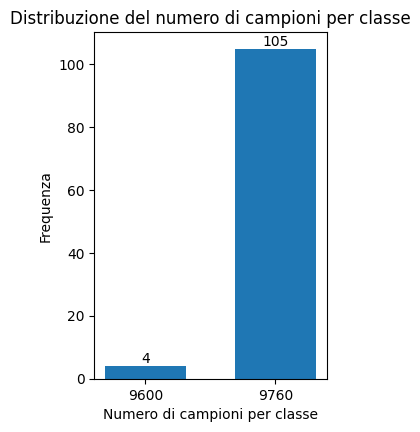

In [ ]:
#@title Campioni per classe

# Conta la frequenza di ciascun numero di campioni
campioni_per_classe = Counter(df_info['Numero Campioni'])

# Ottieni i numeri di campioni (x) e le loro frequenze (y)
x = list(campioni_per_classe.keys())
y = list(campioni_per_classe.values())

# Genera il bar chart
plt.figure(figsize=(3, 4.5))
bars = plt.bar(x, y, width=100.0, align='center')
plt.xlabel("Numero di campioni per classe")
plt.ylabel("Frequenza")
plt.title("Distribuzione del numero di campioni per classe")
plt.xticks(x)                                                                   # Mostra tutte le etichette sull'asse x

# Aggiungi i valori sopra ogni barra
for bar, freq in zip(bars, y):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(freq),
             ha='center', va='bottom')

plt.show()

Possiamo facilmente notare come il dataset risulti quasi perfettamente bilanciato con la presenza di sole 4 classi aventi un numero di campioni leggermente differente.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

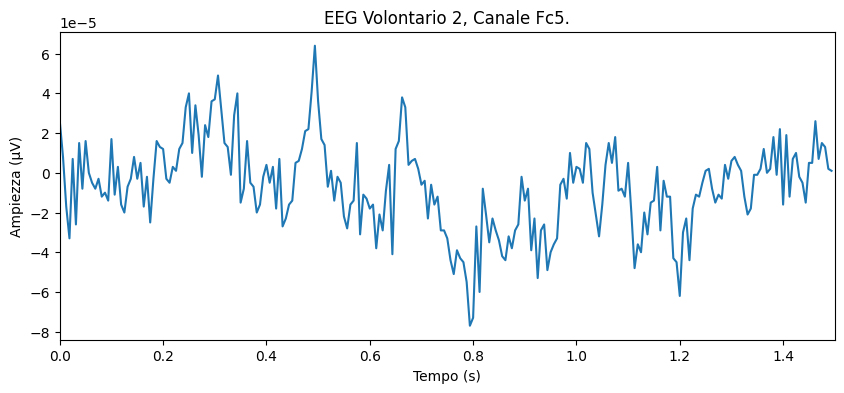

In [ ]:
#@title Mostriamo una parte di un campione qualsiasi
#@markdown Inserisci il numero del volontario (1-109):
volontario = 2 #@param {type:"integer"}
#@markdown Inserisci il range di canali da visualizzare (1-64):
canale_start = 0 #@param {type:"integer"}
canale_end = 1 #@param {type:"integer"}
#@markdown Inserisci il tempo da visualizzare (1-61):
tempo_start = 0 #@param {type:"number"}
tempo_end = 1.5 #@param {type:"number"}

eeg = files[volontario-1]
raw_data = mne.io.read_raw_edf(f"{dataset_path}/{eeg}", preload=True, verbose='CRITICAL')

# Estrai i dati per i canali e il periodo di tempo selezionati
data, times = raw_data[list(range(canale_start -1 , canale_end -1 )), int(tempo_start * raw_data.info['sfreq']):int(tempo_end * raw_data.info['sfreq'])]

# Crea il grafico
plt.figure(figsize=(10, 4))
plt.plot(times, data.T)
plt.xlabel('Tempo (s)')
plt.ylabel('Ampiezza (µV)')
# Ottieni il nome del canale
nome_canale = raw_data.info['ch_names'][canale_end - 1]

plt.title(f"EEG Volontario {volontario}, Canale {nome_canale}") # Stampa il nome del canale nel titolo
plt.xlim([tempo_start, tempo_end]) # Imposta i limiti dell'asse x
plt.show()

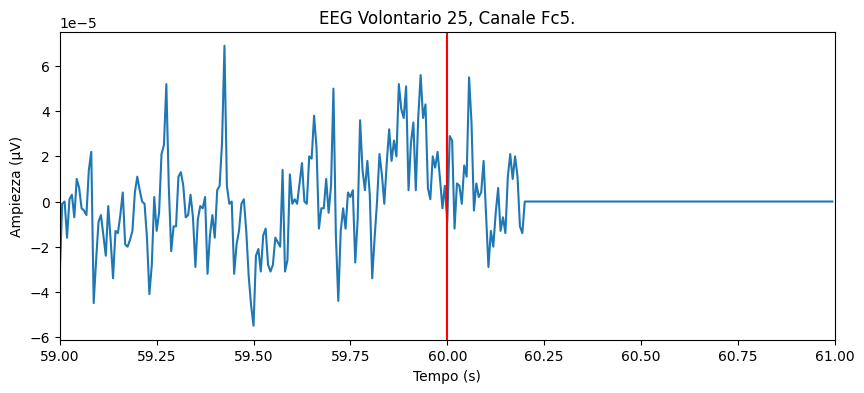

In [ ]:
#@title Mostriamo una parte di un campione qualsiasi
#@markdown Inserisci il numero del volontario (1-109):
volontario = 25 #@param {type:"integer"}
#@markdown Inserisci il range di canali da visualizzare (1-64):
canale_start = 0 #@param {type:"integer"}
canale_end = 1 #@param {type:"integer"}
#@markdown Inserisci il tempo da visualizzare (1-61):
tempo_start = 59 #@param {type:"number"}
tempo_end = 61 #@param {type:"number"}

eeg = files[volontario-1]
raw_data = mne.io.read_raw_edf(f"{dataset_path}/{eeg}", preload=True, verbose='CRITICAL')

# Estrai i dati per i canali e il periodo di tempo selezionati
data, times = raw_data[list(range(canale_start -1 , canale_end -1 )), int(tempo_start * raw_data.info['sfreq']):int(tempo_end * raw_data.info['sfreq'])]

# Crea il grafico
plt.figure(figsize=(10, 4))
plt.plot(times, data.T)
plt.xlabel('Tempo (s)')
plt.ylabel('Ampiezza (µV)')
# Ottieni il nome del canale
nome_canale = raw_data.info['ch_names'][canale_end - 1]

plt.title(f"EEG Volontario {volontario}, Canale {nome_canale}") # Stampa il nome del canale nel titolo
plt.xlim([tempo_start, tempo_end]) # Imposta i limiti dell'asse x

# Aggiungi la linea rossa verticale al 60esimo secondo
plt.axvline(x=60, color='red')

plt.show()

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Come mostrato in questa <a href="https://physionet.org/content/eegmmidb/1.0.0/64_channel_sharbrough.pdf">figura</a>, gli EEG sono stati registrati da 64 elettrodi secondo il sistema internazionale 10-10 (esclusi gli elettrodi Nz, F9, F10, FT9, FT10, A1, A2, TP9, TP10, P9 e P10) ad una frequenza di campionamento pari a 160 Hz. La run utilizzata nel nostro dataset prevede una durata di circa un minuto.

In [ ]:
#@title Report valori anomali

#Verifichiamo che tutti i file abbiano lo stesso numero di canali, la stessa frequenza di campionamento e la stessa durata andando a confrontare ogni valore con la moda
num_canali = df_info['Numero Canali'].mode()[0]
freq_camp = df_info['Frequenza Campionamento (Hz)'].mode()[0]
durata = df_info['Durata (s)'].mode()[0]
report = {
    "Numero Canali Differenti": df_info[df_info['Numero Canali'] != num_canali],
    "Frequenza Campionamento Differente": df_info[df_info['Frequenza Campionamento (Hz)'] != freq_camp],
    "Durata Differente": df_info[df_info['Durata (s)'] != durata]
}

# Stampiamo tutti i valori che sono risultati anomali
for key, value in report.items():
    if not value.empty:
        print(f"{key}:")
        display(value)
    else:
        print(f"Tutti i file hanno {key.split(' ')[0].lower()} coerente.")

print(f"La sessione comune di run dura {df_info['Durata (s)'].mode()[0]} secondi")

Tutti i file hanno numero coerente.
Tutti i file hanno frequenza coerente.
Durata Differente:


,File,Numero Campioni,Frequenza Campionamento (Hz),Numero Canali,Durata (s)
13,S014R01.edf,9600,160.0,64,60.0
50,S051R01.edf,9600,160.0,64,60.0
68,S069R01.edf,9600,160.0,64,60.0
108,S109R01.edf,9600,160.0,64,60.0


La sessione comune di run dura 61.0 secondi


Riscontriamo che la frequenza di campionamento e il numero di canali utilizzati sono coerenti per tutto il dataset. Gli unici valori "anomali" presenti riguardano i 4 volontari aventi meno campioni. Ciò è dovuto alla durata minore di un secondo della loro sessione di run rispetto a quella comune a tutti gli altri volontari. Infatti, una tipica sessione prevede un secondo extra, pratica molto comune nei protocolli sperimentali al fine di garantire la stabilità e sincronizzazione dei segnali.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Secondo il teorema di Nyquist, la massima frequenza rappresentabile senza ambiguità in un segnale campionato è pari a metà della frequenza di campionamento. Per garantire che le successive analisi siano accurate e prive di ambiguità (fenomeno dell'aliasing), prenderemo come frequenza massima il limite di Nyquist.

In [ ]:
fmax = freq_camp/2
print(f"Nel nostro caso la frequenza massima sarà: {fmax} Hz")

Nel nostro caso la frequenza massima sarà: 80.0 Hz


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

La Power Spectral Density (PSD) è una delle analisi di base più utilizzate negli studi EEG per comprendere la distribuzione delle frequenze nel segnale, in quanto aiuta a identificare canali rumorosi o saturi e a verificare la qualità del segnale. Qui di seguito utilizziamo la PSD media ottenuta da ciascun volontario per ogni canale. Questa ci permette di ottenere una rappresentazione generale della distribuzione delle frequenze nel dataset e di analizzare la coerenza delle risposte EEG a livello di gruppo.

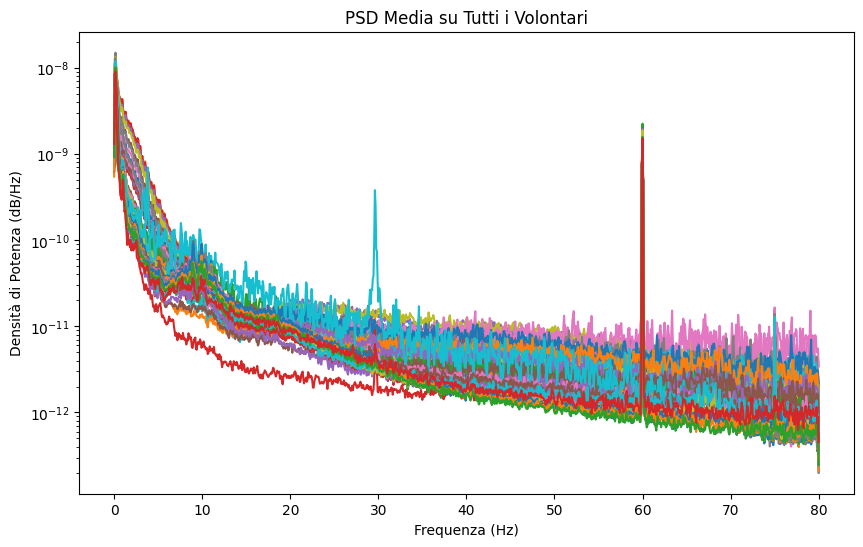

In [ ]:
#@title Valutazione della Coerenza delle Frequenze nel Dataset tramite la PSD media per canale

psd_totale = None
psd_frequenze = None

for eeg in files:
    raw_data = mne.io.read_raw_edf(f"{dataset_path}/{eeg}", preload=True, verbose='CRITICAL')
    psd, freqs = raw_data.compute_psd(fmax=fmax, verbose=False).get_data(return_freqs=True)  # Calcola la PSD e ottieni le frequenze

    # Somma la PSD per ciascun volontario
    if psd_totale is None:
        psd_totale = psd
        psd_frequenze = freqs
    else:
        psd_totale += psd

# Calcola la media della PSD
psd_media = psd_totale / numero_classi

# Visualizza la PSD media
plt.figure(figsize=(10, 6))
plt.yscale('log')                                                               # Imposta una scala logaritmica sull'asse delle potenze
plt.plot(psd_frequenze, psd_media.T)                                            # PSD media per ogni canale
plt.xlabel('Frequenza (Hz)')
plt.ylabel('Densità di Potenza (dB/Hz)')
plt.title('PSD Media su Tutti i Volontari')
plt.show()


Canali con picco a 60 Hz:
Canale 4: Fcz.
Canale 11: Cz..
Canale 12: C2..
Canale 16: Cp3.
Canale 18: Cpz.
Canale 19: Cp2.


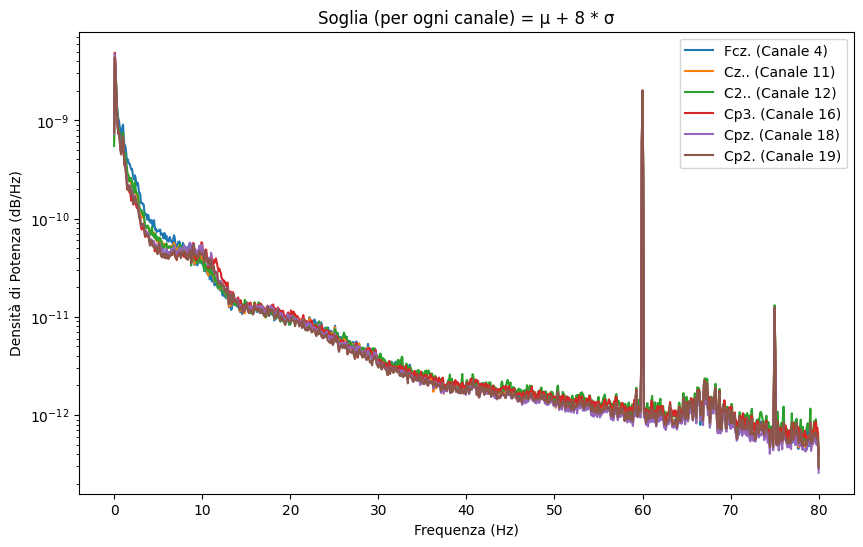

In [ ]:
# Trova i canali con picco a 60 Hz rispetto alla media del singolo canale
indice_60hz = np.argmin(np.abs(psd_frequenze - 60))
tutti_canali = []
nomi_canali = raw_data.info["ch_names"]

for i in range(psd_media.shape[0]):
    soglia_picco = np.mean(psd_media[i, :]) + 8 * np.std(psd_media[i, :])
    if psd_media[i, indice_60hz] > soglia_picco:
        tutti_canali.append((i, nomi_canali[i]))

# Stampa i canali con picco significativo a 60 Hz
print("Canali con picco a 60 Hz:")
for i, nome in tutti_canali:
    print(f"Canale {i+1}: {nome}")

# Plotta i canali con picco a 60 Hz usando scala logaritmica
plt.figure(figsize=(10, 6))
plt.yscale('log')
for i, nome in tutti_canali:
    plt.plot(psd_frequenze, psd_media[i], label=f"{nome} (Canale {i+1})")
plt.xlabel('Frequenza (Hz)')
plt.ylabel('Densità di Potenza (dB/Hz)')
plt.title('Soglia (per ogni canale) = μ + 8 * σ')
plt.legend()
plt.show()


I segnali EEG tendono naturalmente ad avere potenza più alta alle frequenze basse. Questo è dovuto sia alla natura del segnale cerebrale stesso, sia al fatto che i segnali ad alta frequenza vengono attenuati in modo più significativo nel passaggio attraverso il cranio e il cuoio capelluto. Per questo motivo è stata scelta una scala logaritmica per l'asse delle ordinate, permettendo così una visione più dettagliata delle frequenze più alte. Si nota dal grafico come ci siano dei picchi, comuni a più canali, per la frequenza pari a 60 Hz, probabilmente dovuti alla interferenza della corrente elettrica ambientale statunitense. Questo dettaglio verrà tenuto in considerazione nel pre-processing.

Con il prossimo grafico a barre è possibile vedere la distribuzione della potenza media divisa per le bande di frequenza (in Hz) più comunemente studiate nei segnali EEG:

*   Delta (0.5 - 4): caratterizzano gli stadi di sonno profondo;
*   Theta (4 - 8): caratterizzano gli stadi 1 e 2 del sonno NREM e il sonno REM;
*   Alpha (8 - 13): tipiche della veglia ad occhi chiusi e degli istanti precedenti l'addormentamento;
*   Beta (13 - 30): si registrano in un soggetto in stato di veglia, nel corso di una intensa attività mentale e soprattutto da aree cerebrali frontali;
*   Gamma (30 - 40): caratterizzano gli stati di particolare tensione.

A queste bande abbiamo voluto aggiungere la broadband ed due bande personalizzate (limitando in maniere diverse il rumore dei dati):
*   Broadband (1 - 80): applica un filtro passa-alto;
*   Personalizzata (1 - 40): applica sia un filtro passa-alto che passa-basso;
*   ABG (8 - 40): copre il range delle onde alpha, beta e gamma.





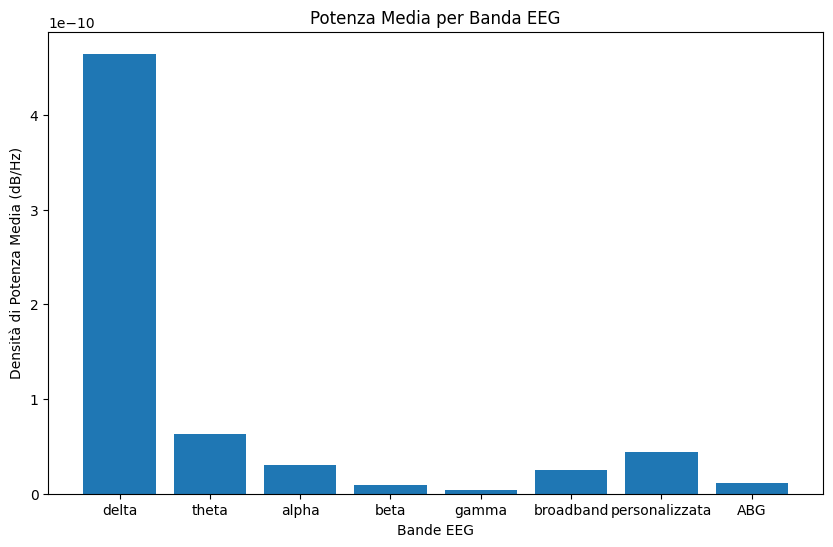

In [ ]:
# Esempio per calcolare e visualizzare la potenza media per bande
bande = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30), 'gamma': (30, 40), 'broadband': (1, float(fmax)-0.1), 'personalizzata': (1, 40), 'ABG': (8,40)}

potenza_bande = {}
for banda, limiti in bande.items():
    # Seleziona le frequenze all'interno della banda
    indici_frequenze = (psd_frequenze >= limiti[0]) & (psd_frequenze <= limiti[1])

    # Calcola la potenza media per la banda su tutti i canali
    # .mean(axis=1) calcola la media lungo la dimensione delle frequenze (axis=1)
    # .mean() calcola la media su tutti i canali
    potenza_bande[banda] = np.mean(psd_media[:, indici_frequenze].mean(axis=1))

plt.figure(figsize=(10, 6))
plt.bar(potenza_bande.keys(), potenza_bande.values())
plt.xlabel('Bande EEG')
plt.ylabel('Densità di Potenza Media (dB/Hz)')
plt.title('Potenza Media per Banda EEG')
plt.show()

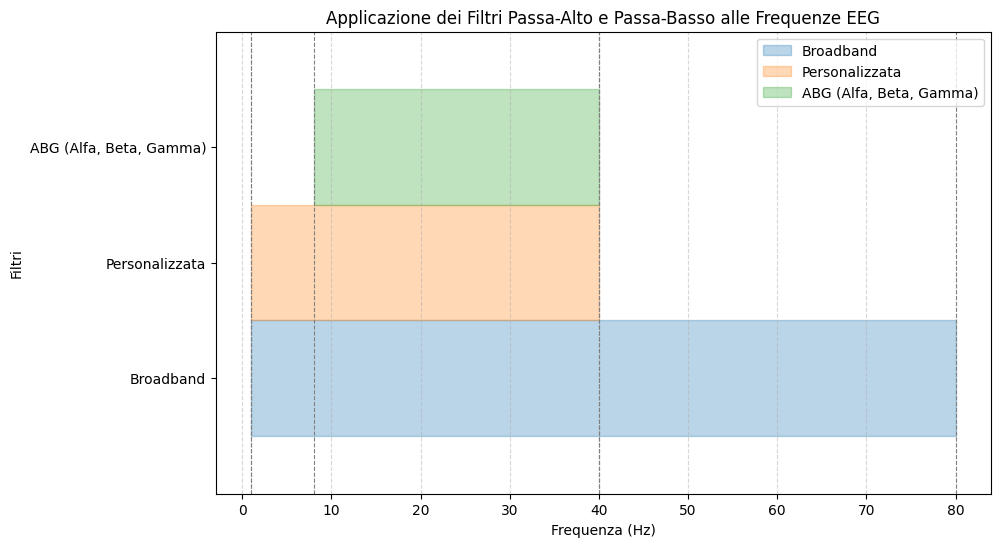

In [ ]:
# Definizione delle bande di frequenza
filters = {
    "Broadband": (1, 80),
    "Personalizzata": (1, 40),
    "ABG (Alfa, Beta, Gamma)": (8, 40)
}

# Creazione del grafico
plt.figure(figsize=(10, 6))

# Dati per l'asse delle frequenze
frequencies = np.linspace(0, 100, 1000)  # Frequenze da 0 a 100 Hz

# Disegno dei filtri come aree colorate
for i, (label, (low, high)) in enumerate(filters.items()):
    plt.fill_betweenx(
        y=[0.5 + i, 1.5 + i],  # Posizione verticale del filtro
        x1=low, x2=high,
        color=f"C{i}", alpha=0.3, label=label
    )

# Linee guida per i filtri
for low, high in filters.values():
    plt.axvline(low, color='gray', linestyle='--', linewidth=0.8)
    plt.axvline(high, color='gray', linestyle='--', linewidth=0.8)

# Personalizzazione del grafico
plt.xlabel("Frequenza (Hz)")
plt.ylabel("Filtri")
plt.title("Applicazione dei Filtri Passa-Alto e Passa-Basso alle Frequenze EEG")
plt.legend(loc="upper right")
plt.ylim(0, len(filters) + 1)
plt.yticks([1 + i for i in range(len(filters))], filters.keys())
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Mostra il grafico
plt.show()


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Per permettere una analisi approfondita riguardo uno specifico EEG, qui di seguito è possibile selezionare un determinato volontario.

In [ ]:
#@title Seleziona il volontario per cui vuoi effettuare ulteriori analisi

#@markdown Inserisci il numero del volontario (1-109):

volontario = 50 #@param {type:"integer"}
eeg = files[volontario-1]
raw_data = mne.io.read_raw_edf(f"{dataset_path}/{eeg}", preload=True, verbose='CRITICAL')


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

La PSD di uno specifico EEG permette di osservare la distribuzione delle frequenze di ciascun volontario singolarmente e di fare un confronto visivo tra loro.

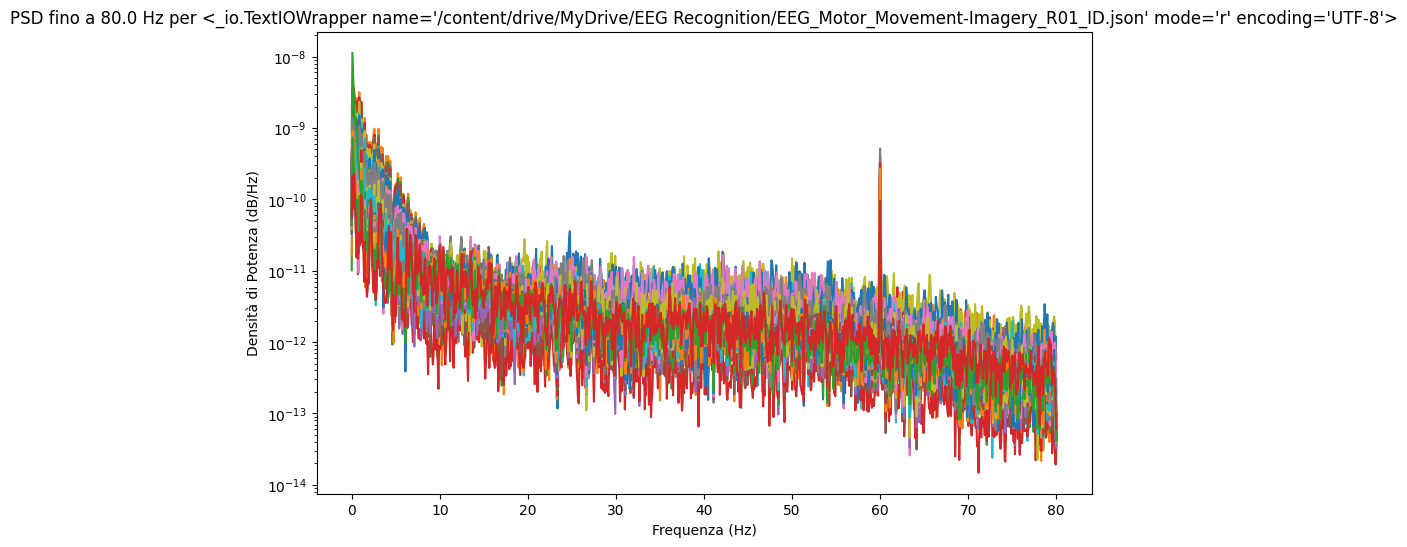

In [ ]:
#@title PSD per canale per singolo volontario

# Calcola la PSD usando il metodo `compute_psd`
psd_data = raw_data.compute_psd(fmax=fmax, verbose=False)

# Ottieni i dati della PSD e le frequenze
psd, freqs = psd_data.get_data(return_freqs=True)

# Visualizza la PSD per ogni canale
plt.figure(figsize=(10, 6))
plt.plot(freqs, psd.T)                                                          # Trasponiamo `psd` per avere ogni canale su una linea separata
plt.xlabel('Frequenza (Hz)')
plt.ylabel('Densità di Potenza (dB/Hz)')
plt.title(f'PSD fino a {fmax} Hz per {file}')
plt.yscale('log')                                                               # Imposta la scala logaritmica se necessario
plt.show()

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Un boxplot per ciascun canale di un singolo EEG fornisce una panoramica generale della distribuzione e della variabilità del segnale, mostrando se ci sono valori fuori scala o canali con ampiezze insolite.

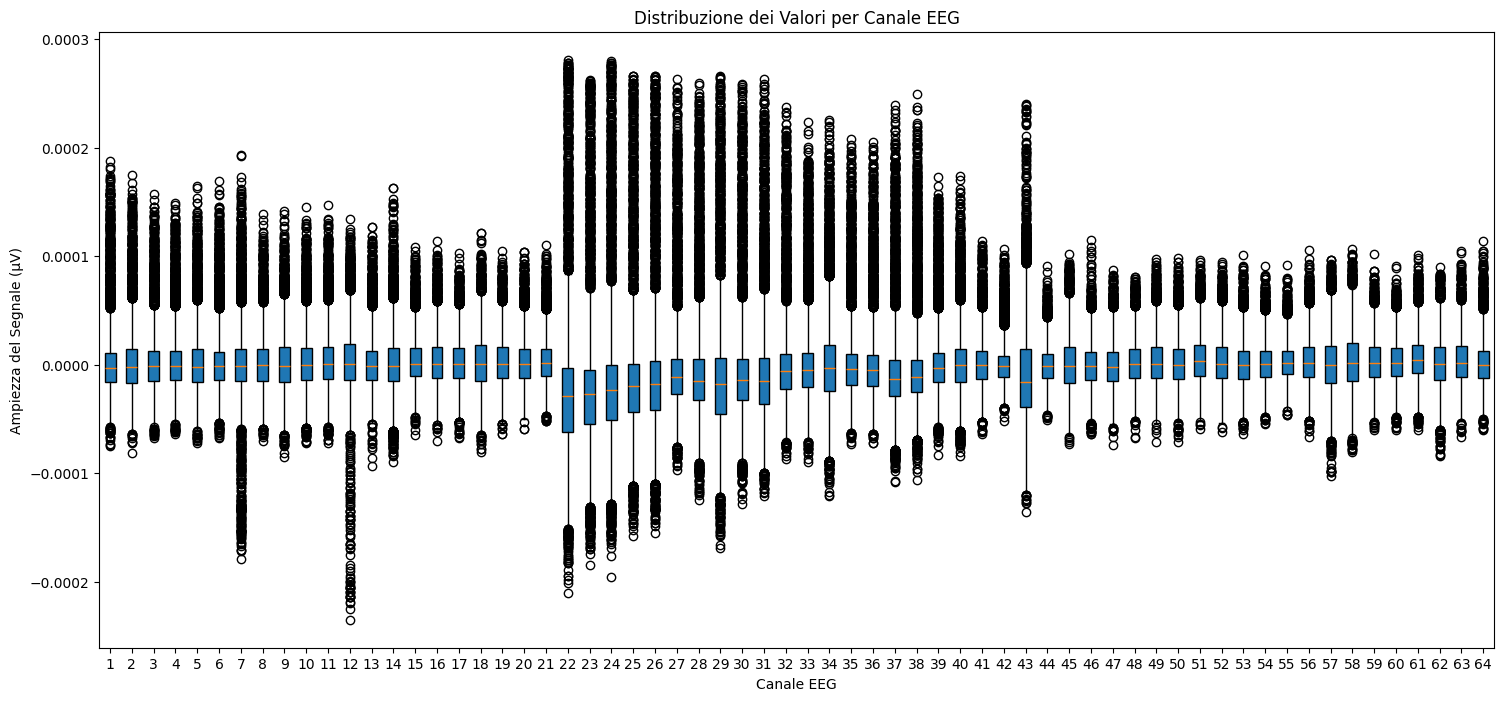

In [ ]:
#@title Boxplot per canale per singolo volontario

data = raw_data.get_data()  # Dimensioni: (n_channels, n_times)

# Creare un boxplot per ciascun canale
plt.figure(figsize=(18, 8))
plt.boxplot(data.T, patch_artist=True)
plt.xlabel("Canale EEG")
plt.ylabel("Ampiezza del Segnale (μV)")
plt.title("Distribuzione dei Valori per Canale EEG")
plt.show()

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Con il codice successivo è possibile effettuare lo spettrogramma, utile ad analizzare come le frequenze variano nel tempo e a individuare eventuali cambiamenti dinamici nel segnale EEG.

In [ ]:
#@title Seleziona il canale per cui vuoi effettuare lo spettrogramma

#@markdown Inserisci il numero del canale (1-64):

canale = 4 #@param {type:"integer"}
canale -= 1

# Genera uno spettrogramma per il canale selezionato del volontario scelto
f, t, Sxx = spectrogram(data[canale, :], fs=raw_data.info['sfreq'])


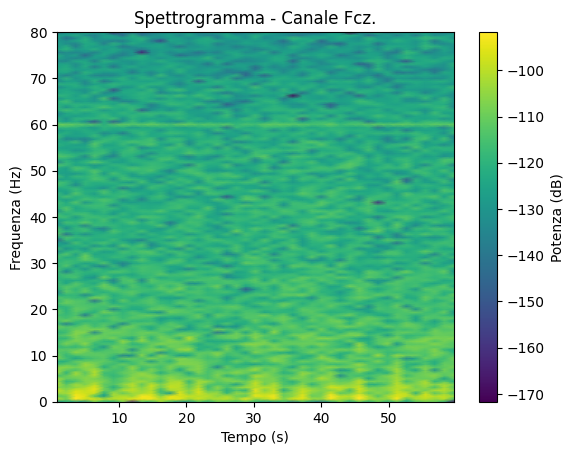

In [ ]:
#@title Spettrogramma 2D
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequenza (Hz)')
plt.xlabel('Tempo (s)')
plt.title(f'Spettrogramma - Canale {raw_data.info["ch_names"][canale]}')
plt.colorbar(label='Potenza (dB)')
plt.show()

Per permettere una visione più chiara viene offerta anche una prospettiva 3D.

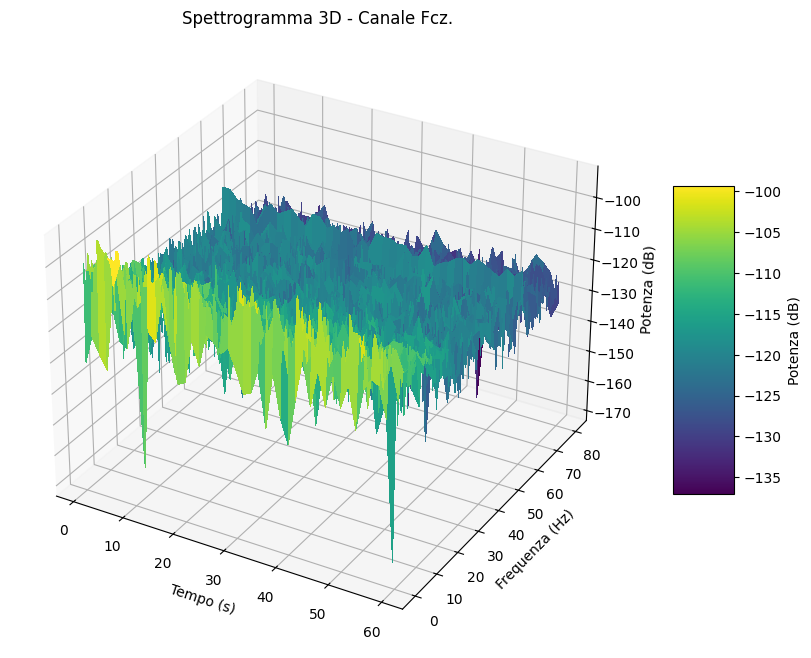

In [ ]:
#@title Spettrogramma 3D

# Crea una figura 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Crea una meshgrid per le coordinate X e Y
T, F = np.meshgrid(t, f)

# Plotta la superficie 3D
surf = ax.plot_surface(T, F, 10 * np.log10(Sxx), cmap=cm.viridis,
                       linewidth=0, antialiased=False)

# Imposta le etichette degli assi
ax.set_xlabel('Tempo (s)')
ax.set_ylabel('Frequenza (Hz)')
ax.set_zlabel('Potenza (dB)')
ax.set_title(f'Spettrogramma 3D - Canale {raw_data.info["ch_names"][canale]}')

# Aggiungi una colorbar
fig.colorbar(surf, shrink=0.5, aspect=5, label='Potenza (dB)')

plt.show()

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Non avendo sufficiente competenze da poter verificare visivamente qualora un canale sia cattivo oppure no, non abbiamo etichettato nessun canale come tale.
Non avendo nemmeno informazioni aggiuntive su eog  e ecg, non abbiamo potuto fare affidamento sull'ICA (Independent Component Analysis) per quanto riguarda la rimozione degli artefatti (come movimenti oculari, battiti cardiaci e interferenze elettriche).

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Infine viene calcolata la matrice di correlazione tra i canali, utile per rilevare ridondanza nei segnali.

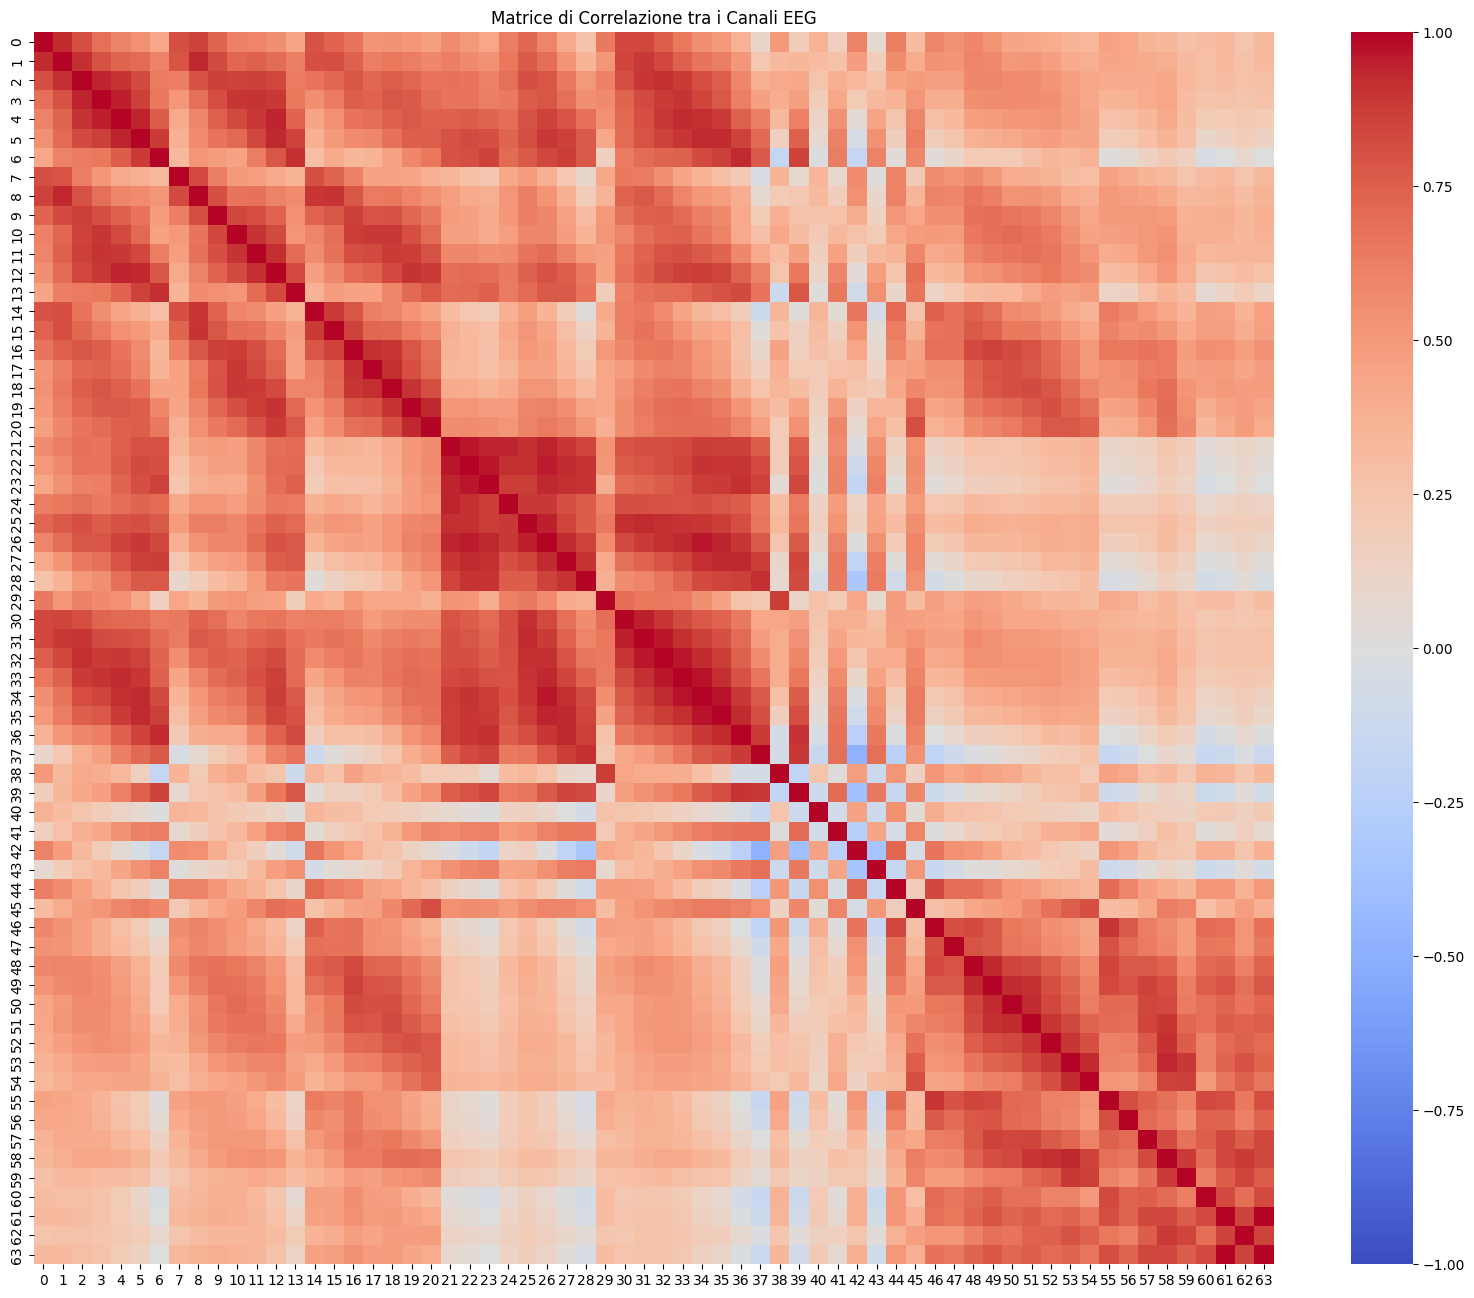

In [ ]:
#@title Matrice di correlazione tra canali
corr_matrix = pd.DataFrame(data).T.corr()

# Plot della matrice di correlazione
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matrice di Correlazione tra i Canali EEG")
plt.show()

Selezionado vari EEG, dalla matrice si evince sempre una forte presenza di alte correlazioni tra i canali.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Data la rindondanza dei dati decidiamo di verificare quanto sarebbe possibile ridurre il dataset tramite la Principal Component Analisys a seconda della varianza che si vuole mantenere nelle informazioni.

Riteniamo 0.95 una buona soglia, utile tra l'altro a ridurre il rumore. Per sperimentare è possibile cambiare tale valore.

In [ ]:
#@title Seleziona un valore per la varianza

#@markdown Inserisci un valore (0.01 - 1.00):

soglia = 0.95 #@param

Numero di componenti principali necessari per spiegare almeno il 95.0% della varianza: 37



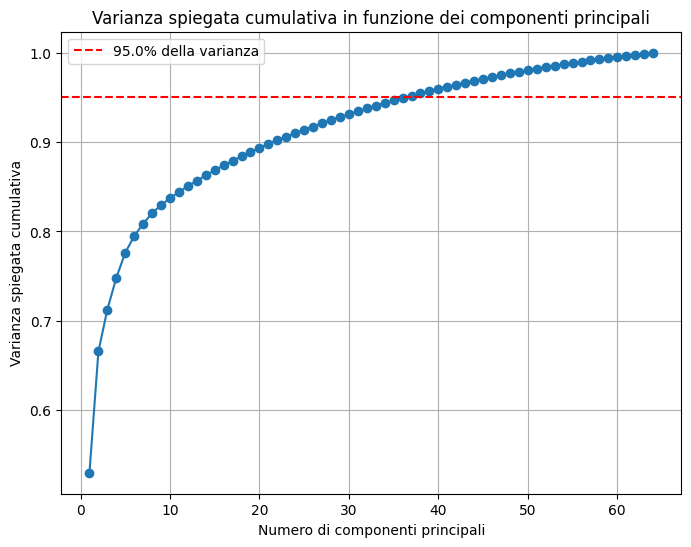

In [ ]:
#@title Numero di componenti principali per soglia di varianza

# Lista per memorizzare tutti i dati dai file .edf
all_data = []

# Carica e concatena i dati da ogni file .edf
for eeg in files:
    raw_data = mne.io.read_raw_edf(f"{dataset_path}/{eeg}", preload=True, verbose='CRITICAL')
    data = raw_data.get_data()                                                  # Ottieni i dati come array (n_channels, n_times)
    all_data.append(data.T)                                                     # Trasponi per ottenere (n_times, n_channels)

# Concatenazione di tutti i dati lungo l'asse temporale
all_data = np.concatenate(all_data, axis=0)                                     # Dimensioni finali: (n_samples_totali, n_channels)

# Esegui la PCA sui dati concatenati
pca = PCA()
pca.fit(all_data)

# Calcola la varianza spiegata cumulativa
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Trova il numero di componenti principali per superare la soglia di varianza
n_components = np.argmax(explained_variance >= soglia) + 1                      # Aggiungi 1 per ottenere il conteggio corretto
print(f"Numero di componenti principali necessari per spiegare almeno il {soglia * 100}% della varianza: {n_components}\n")

# Grafico della varianza spiegata cumulativa
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel("Numero di componenti principali")
plt.ylabel("Varianza spiegata cumulativa")
plt.title("Varianza spiegata cumulativa in funzione dei componenti principali")
plt.axhline(y=soglia, color='r', linestyle='--', label=f"{soglia * 100}% della varianza")
plt.legend()
plt.grid(True)
plt.show()


<a name="4"></a>
# **Preprocessing**

Grazie alle analisi svolte sino a questo momento, ora è possibile iniziare a lavorare con i dati al fine di trasformarli per una elaborazione più efficiente da parte dei classificatori.

Questa fase si divide in tre punti:
*   segmentare i record EEG in campioni di 1,5 secondi;
*   analizzare come le prestazioni cambiano modificando il filtro della banda del segnale;
*   suddividere i campioni in 70% per l'addestramento, 15% per la validazione e il 15% rimanente per il test.


In [ ]:
#@title Parametri segmentazione e suddivisione
duration = 1.5
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

Salveremo dentro delle apposite cartelle tutti i dataset preprocessati divisi per banda.

In [ ]:
save_path = '/content/drive/MyDrive/EEG Recognition/Dati preprocessati/'

# Verifica se la cartella esiste già
if not os.path.exists(save_path):
    os.makedirs(save_path)                                                      # Crea la cartella
    print(f"Cartella '{save_path}' creata con successo.")
else:
    print(f"La cartella '{save_path}' esiste già.")

La cartella '/content/drive/MyDrive/EEG Recognition/Dati preprocessati/' esiste già.


In [ ]:
#@title Seleziona la banda che vuoi utilizzare:

#@markdown (delta, theta, alpha, beta, gamma, broadband, personalizzata, ABG)

banda = 'broadband' #@param ['delta', 'theta', 'alpha', 'beta', 'gamma', 'broadband', 'personalizzata', 'ABG']
save_path = '/content/drive/MyDrive/EEG Recognition/Dati preprocessati/R01/'+banda

# Verifica se la cartella esiste già
if not os.path.exists(save_path):
    os.makedirs(save_path)                                                      # Crea la cartella
    print(f"Cartella '{save_path}' creata con successo.")
else:
    print(f"La cartella '{save_path}' esiste già.")

La cartella '/content/drive/MyDrive/EEG Recognition/Dati preprocessati/R01broadband/' esiste già.


Per una questione di efficienza eseguiremo tutto il preprocessamento in un unico blocco di codice nel seguente ordine:

*   filtro passa-banda: creiamo un dataset da salvare per la banda selezionata;

*   filtro notch: applichiamo questo filtro solo nelle bande necessarie;

*   segmentazione in epoche: segmentiamo i campioni in finestre di 1.5 secondi senza sovrapposizione;

*   conversione da float64 a float32: la libreria MNE legge i dati in float 64 e non dispone di una funzione per la conversione. Per evitare danneggiamento dei dati aspettiamo di finire con tutte le operazioni svolte da MNE prima di convertire i dati in float32 per ottenere un guadagno computazionale senza perdere dati rilevanti al nostro scopo;

*   Principal Component Analysis (PCA): riduce la dimensionalità del dataset, tenendo in considerazione un valore soglia di varianza da noi precedentemente selezionato;

*   normalizzazione dei dati: aiuta a ottenere una distribuzione uniforme tra i canali EEG, il che permette ai modelli di lavorare in modo più stabile;

*   salvateggio dei file in formato .npy in apposite cartelle.




In [ ]:
#@title Scegliere se applicare la PCA

esegui_pca = False #@param {type:"boolean"}

In [ ]:
# Liste per memorizzare i segmenti e le etichette di train, validation e test
all_train_data = []
all_val_data = []
all_test_data = []
all_train_labels = []
all_val_labels = []
all_test_labels = []

freteamericana = 60
psd_totale = None
psd_frequenze = None
# Ciclo su tutti i file .edf
for i, eeg in enumerate(files):
    print(f"Elaborazione del volontario {i + 1} su {len(files)}\n")

    # Carica il file EDF
    raw_data = mne.io.read_raw_edf(f"{dataset_path}/{eeg}", preload=True, verbose = 'CRITICAL')
    label = i                                                                   # Ottieni l'etichetta del file corrente

    if bande[banda][1] >= freteamericana:
      raw_data.notch_filter(freqs=freteamericana)

    psd, freqs = raw_data.compute_psd(fmax=fmax, verbose=False).get_data(return_freqs=True)  # Calcola la PSD e ottieni le frequenze

    # Somma la PSD per ciascun volontario
    if psd_totale is None:
        psd_totale = psd
        psd_frequenze = freqs
    else:
        psd_totale += psd

    # Filtro per bande
    raw_data.filter(l_freq=bande[banda][0], h_freq=bande[banda][1], n_jobs=8, verbose = 'CRITICAL')

    # Creazione delle epoche a lunghezza fissa
    epochs = mne.make_fixed_length_epochs(raw_data, duration=duration, overlap=0)

    # Estrazione dei dati come array NumPy
    data = epochs.get_data()                                                    # Dimensioni: (n_epochs, n_channels, n_times)

    # Ora, dopo aver terminato tutte le operazioni di `mne`, si può convertire i dati in float32
    data = data.astype(np.float32)

    if(esegui_pca):
      pca = PCA(n_components=n_components)
      data = np.array([pca.fit_transform(epoch.T) for epoch in data])           # Riduci ogni epoca
    else:
      data = np.array([epoch.T for epoch in data])                              # Riduci ogni epoca

    clear_output(wait=True)

    # Genera le etichette per ciascuna epoca
    labels_for_file = [label] * len(data)                                       # Assegna la stessa etichetta a tutte le epoche del file

    # Calcolo del numero di segmenti per ciascun set (train, val, test)
    n_samples = len(data)
    n_train = int(n_samples * train_ratio)
    n_val = int(n_samples * val_ratio)

    train_data, val_data, test_data = data[:n_train], data[n_train:n_train + n_val], data[n_train + n_val:]
    train_labels, val_labels, test_labels = labels_for_file[:n_train], labels_for_file[n_train:n_train + n_val], labels_for_file[n_train + n_val:]

    # Aggiungi i segmenti e le etichette di questo file alle liste globali
    all_train_data.append(train_data)
    all_val_data.append(val_data)
    all_test_data.append(test_data)
    all_train_labels.extend(train_labels)
    all_val_labels.extend(val_labels)
    all_test_labels.extend(test_labels)

# Concatena tutti i segmenti e le etichette
train_data = np.concatenate(all_train_data, axis=0)
val_data = np.concatenate(all_val_data, axis=0)
test_data = np.concatenate(all_test_data, axis=0)
train_labels = np.array(all_train_labels)
val_labels = np.array(all_val_labels)
test_labels = np.array(all_test_labels)

# Calcola la media e la deviazione standard globali (usando solo i dati di train per evitare leakage)
media = np.mean(train_data, axis=(0, 1))
dev_std = np.std(train_data, axis=(0, 1))

# Normalizza i dati di train, validation e test usando la media e la deviazione standard
train_data = (train_data - media) / dev_std
val_data = (val_data - media) / dev_std
test_data = (test_data - media) / dev_std

# Verifica le dimensioni dei dataset e delle etichette
print(f"Train set shape: {train_data.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation set shape: {val_data.shape}, Validation labels shape: {val_labels.shape}")
print(f"Test set shape: {test_data.shape}, Test labels shape: {test_labels.shape}")

# Salva i dataset e le etichette in formato .npy
np.save(f"{save_path}/train_data_{banda}.npy", train_data)
np.save(f"{save_path}/train_labels_{banda}.npy", train_labels)
np.save(f"{save_path}/val_data_{banda}.npy", val_data)
np.save(f"{save_path}/val_labels_{banda}.npy", val_labels)
np.save(f"{save_path}/test_data_{banda}.npy", test_data)
np.save(f"{save_path}/test_labels_{banda}.npy", test_labels)


Train set shape: (3052, 240, 64), Train labels shape: (3052,)
Validation set shape: (654, 240, 64), Validation labels shape: (654,)
Test set shape: (654, 240, 64), Test labels shape: (654,)


Una volta salvati i dataset preprocessati di interesse è tutto pronto per poter cambiare notebook e dare tutto in pasto a qualche classificatore.

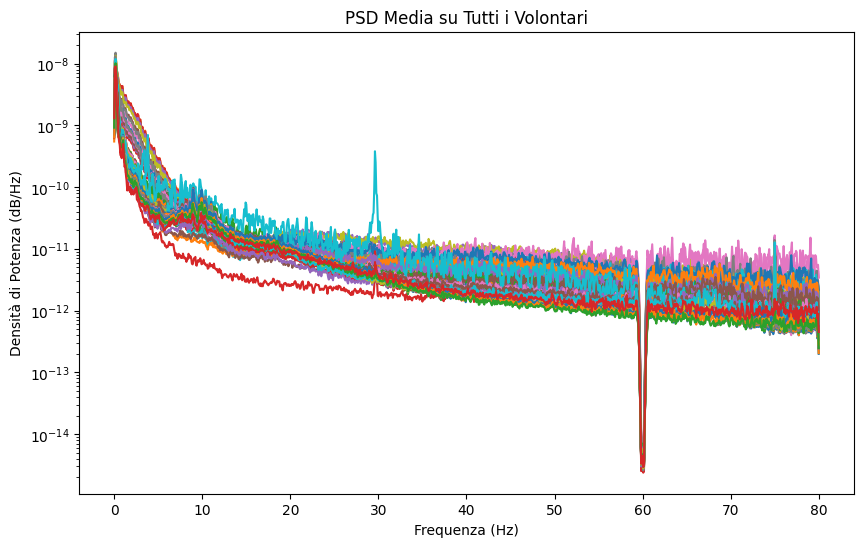

In [ ]:
#@title Valutazione della Coerenza delle Frequenze nel Dataset tramite la PSD media per canale

# Calcola la media della PSD
psd_media = psd_totale / numero_classi

# Visualizza la PSD media
plt.figure(figsize=(10, 6))
plt.yscale('log')                                                               # Imposta una scala logaritmica sull'asse delle potenze
plt.plot(psd_frequenze, psd_media.T)                                            # PSD media per ogni canale
plt.xlabel('Frequenza (Hz)')
plt.ylabel('Densità di Potenza (dB/Hz)')
plt.title('PSD Media su Tutti i Volontari')
plt.show()
